In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

In [2]:
TOKEN_SPAM_PROB_FILE = './03_Testing/prob-spam.txt'
TOKEN_HAM_PROB_FILE = './03_Testing/prob-nonspam.txt'
TOKEN_ALL_PROB_FILE = './03_Testing/prob-all-tokens.txt'
TEST_FEATURE_MATRIX = './03_Testing/test-features.txt'
TEST_TARGET_FILE = './03_Testing/test-target.txt'
VOCAB_SIZE = 2500

# Load the data

In [3]:
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=' ')
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter=' ')

prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter=' ')
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter=' ')
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter=' ')

# Joint Probability (Dot Product)

In [4]:
X_test.dot(prob_token_spam).shape

(1723,)

# Prior 

$$ P(Spam \, | \, X) = \frac{P(X \, | \, Spam \,) \, P(Spam)} {P(X)} $$
$$ P(Ham \, | \, X) = \frac{P(X \, | \, Ham \,) \, (1 - P(Spam))} {P(X)} $$

In [5]:
PROB_SPAM = 0.3116

In [6]:
np.log(prob_token_spam)

array([ -4.70632085,  -5.32161816,  -4.98677062, ...,  -9.20111798,
        -8.70034269, -10.40509078])

# Log Joint Probability

In [7]:
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)

In [8]:
joint_log_spam[:5]

array([  3.21643926,  13.38035269,  19.20668974, -16.61242345,
        27.93765399])

In [9]:
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1-PROB_SPAM)

In [10]:
joint_log_ham[:5]

array([-11.05063426, -36.94310619, -38.25679825,  -2.70364873,
       -60.15266519])

# Making Predictions

$$ P(Spam \, | \, X) \, > \, P(Ham \, | \, X) $$
<br><center><h2>OR</h2></center><br>
$$ P(Spam \, | \, X) \, < \, P(Ham \, | \, X) $$

In [11]:
prediction = joint_log_spam > joint_log_ham

# Simplify

$$ P(X \, | \, Spam) \, P(Spam) \,  ≠ \frac{P(X \, | \, Spam \,) \, P(Spam)} {P(X)} $$

In [12]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(1-PROB_SPAM)

# Metrics and Accuracy

In [13]:
correct_docs = (y_test == prediction).sum()
numdocs_wrong = X_test.shape[0] - correct_docs 
print("Correctly classified: ", correct_docs, "\nIncorrectly classified: ", numdocs_wrong)

Correctly classified:  1671 
Incorrectly classified:  52


In [14]:
accuracy = correct_docs / X_test.shape[0] * 100 
fraction_wrong = numdocs_wrong / X_test.shape[0] * 100 
print("Accuracy: ", accuracy, "\nPercent Incorrectly classified: ", fraction_wrong)

Accuracy:  96.98200812536274 
Percent Incorrectly classified:  3.0179918746372607


# Result Visualization 

In [15]:
yaxis_label = 'P(X | Spam)'
xaxis_label = 'P(X | Nonspam)'
linedata = np.linspace(start=-14000, stop=1, num=1000)

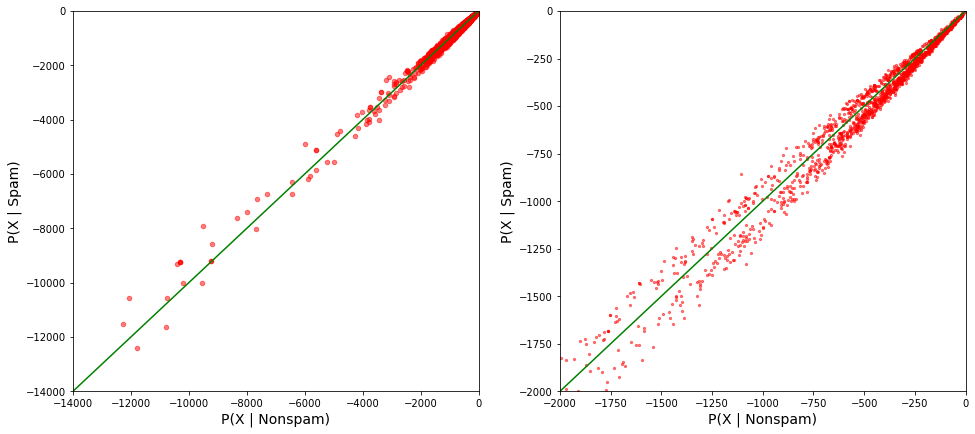

In [16]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='red', alpha=0.5, s=20)
plt.plot(linedata, linedata, color='green')

plt.subplot(1, 2, 2)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='red', alpha=0.5, s=5)
plt.plot(linedata, linedata, color='green')

plt.show()

In [17]:
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({xaxis_label: joint_log_ham, yaxis_label: joint_log_spam, labels: y_test})

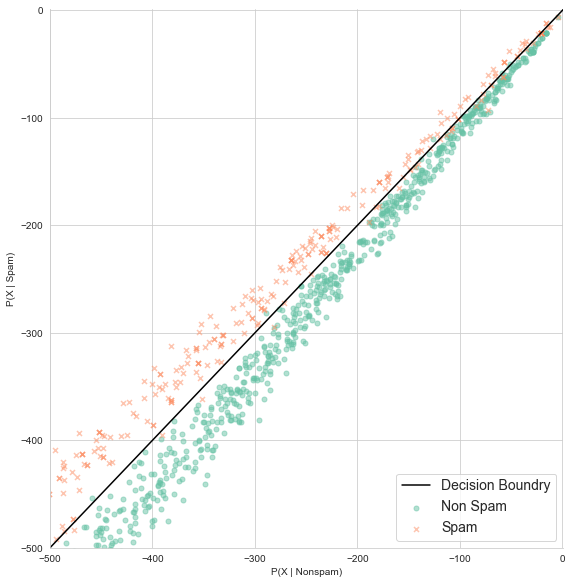

In [18]:
sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, height=8, fit_reg=False, scatter_kws={'alpha': 0.5, 's': 25},
          hue=labels, markers=['o', 'x'], palette='Set2', legend=False)
plt.xlim([-500, 1])
plt.ylim([-500, 1])
plt.plot(linedata, linedata, color='black')

plt.legend(('Decision Boundry', 'Non Spam', 'Spam'), loc='lower right', fontsize=14)
plt.show()

# False Positive and False Negative
## False Positive: mail was actually ham but classified as spam
## False Negative: mail was actually spam but classified as ham

In [23]:
np.unique(prediction, return_counts=True)

(array([False,  True]), array([1163,  560], dtype=int64))

In [29]:
true_pos = (y_test == 1) & (prediction == 1) 
print(true_pos.sum())
true_pos

548


array([ True,  True,  True, ..., False, False, False])

In [28]:
true_neg = (y_test == 0) & (prediction == 0) 
print(true_neg.sum())

1123


In [30]:
false_pos = (y_test == 0) & (prediction == 1) 
print(false_pos.sum())

12


In [33]:
false_neg = (y_test == 1) & (prediction == 0) 
print(false_neg.sum())

40


# Recall Score 
$$ recall score = \frac{true pos \,} {\, (true pos + false neg)} $$

In [38]:
recall_score = true_pos.sum() / (true_pos.sum() + false_neg.sum()) * 100
recall_score

93.19727891156462

# Precision
$$ precision = \frac{true pos \,} {\, (true pos + false pos)} $$
# **Often Recall Score and Precision are inversly proportional to each other**

In [39]:
precision = true_pos.sum() / (true_pos.sum() + false_pos.sum()) * 100
precision

97.85714285714285

# F-score or F1-score: Combining Precision and Recall
$$ F-score = 2 \,  \frac {(Precision) \, (Recall)} {Precision + Recall} $$

In [40]:
f1_score = 2 * precision * recall_score / (precision + recall_score)
f1_score

95.47038327526131